## Titanic

This notebook is creating a machine learning model on Titanic dataset, which has been used by many specially through [kaggle competition ](https://www.kaggle.com/c/titanic). Dataset used here is from [data.world](https://data.world/nrippner/titanic-disaster-dataset).


#### Data Features

`survival - Survival (0 = No; 1 = Yes)
class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
name - Name
sex - Sex
age - Age
sibsp - Number of Siblings/Spouses Aboard
parch - Number of Parents/Children Aboard
ticket - Ticket Number
fare - Passenger Fare
cabin - Cabin
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat - Lifeboat (if survived)
body - Body number (if did not survive and body was recovered)`


In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# loading dataset as a data frame object
df = pd.read_csv("titanic.csv")
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


All the data might not be meaningful for this analysis purpose or some features (like ‘name’) obviously will not have any effect on the fact that a person may survive this disaster or not. So let’s wrangle our data first with dropping following columns:  
__`name, cabin, ticket, boat, body, home.dest`__

In [3]:
df.drop(['name', 'cabin', 'ticket', 'boat', 'body', 'home.dest'], axis=1, inplace=True)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,29.0000,0.0,0.0,211.3375,S
1,1.0,1.0,male,0.9167,1.0,2.0,151.5500,S
2,1.0,0.0,female,2.0000,1.0,2.0,151.5500,S
3,1.0,0.0,male,30.0000,1.0,2.0,151.5500,S
4,1.0,0.0,female,25.0000,1.0,2.0,151.5500,S


### Missing Data

let’s first have a look how is overall quality of our data regarding missing data. Refer to below infographics, __`age`__ is clearly the one with most missing data. However, seems few pieces of data are also missing from __`fare`__ and __`embarked`__

In [4]:
# see https://github.com/ResidentMario/missingno
import missingno as msno

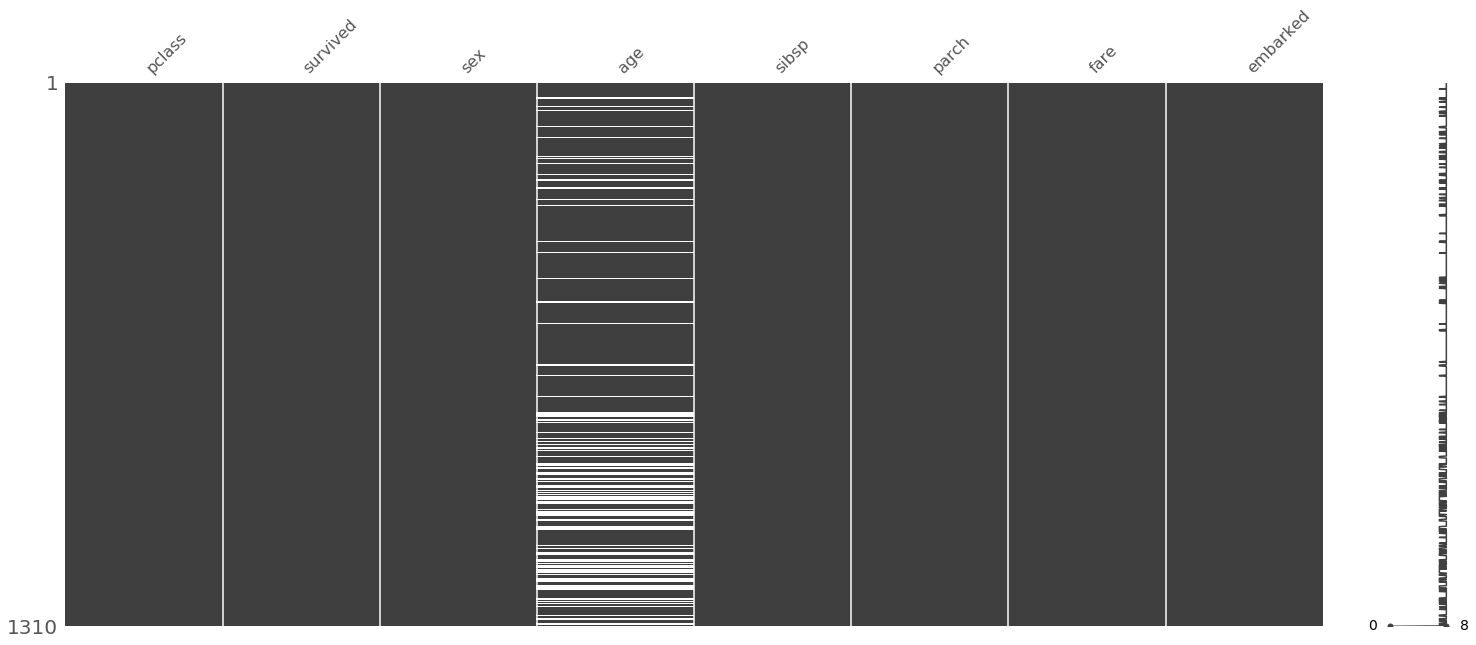

In [5]:
msno.matrix(df)

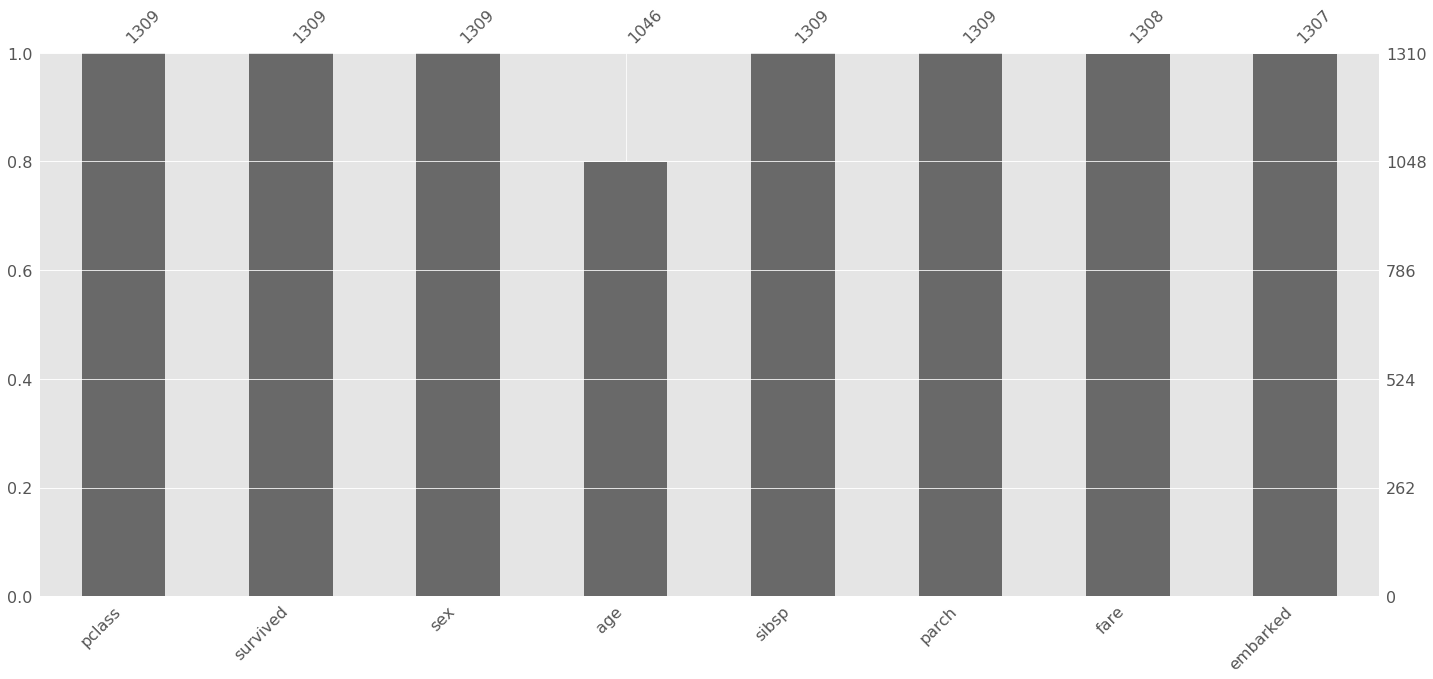

In [6]:
msno.bar(df)

By using `df[‘label’][df[‘label’].isna() == True]` we can browse through data and figure out what are missing and discuss our choice of imputation.
1. last row is all blank and need to be dropped
2. missing __`age`__ values to be replaced with __median__ (see hereunder histogram for __`age`__ distribution).
3. missing value for __`fare`__ to be replaced with __mode__
4. missing value for __`embarked	`__ to be replaced with __mode__

Text(0.5, 1.0, 'Histogram: "age" distribution')

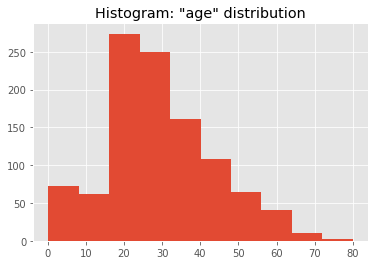

In [7]:
ax = df['age'].hist()
ax.set_title('Histogram: "age" distribution')

In [8]:
# to drop last row (all blank)
df.drop(1309, axis=0, inplace=True)
# to replace 'age' missing values with median
df['age'].fillna(df['age'].median(), inplace=True)
# to replace 'fare' missing values with mode
df['fare'].fillna(df['fare'].mode()[0], inplace=True)
# to replace 'embarked' missing values with mode
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)

In [9]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,29.0000,0.0,0.0,211.3375,S
1,1.0,1.0,male,0.9167,1.0,2.0,151.5500,S
2,1.0,0.0,female,2.0000,1.0,2.0,151.5500,S
3,1.0,0.0,male,30.0000,1.0,2.0,151.5500,S
4,1.0,0.0,female,25.0000,1.0,2.0,151.5500,S


## Exploring Correlation

Let’s navigate through the data a little bit to see if meaningful correlations can be found in selected features: 

First observation is that __`female`__ individuals have a noticeable higher rate of survival.

In [10]:
df[['sex', 'survived']].groupby('sex', as_index=False).mean()

,sex,survived
0,female,0.727468
1,male,0.190985


Also passenger’s classes __`pclass`__ shows a clear effect on survival rate.

In [11]:
df[['pclass', 'survived']].groupby('pclass', as_index=False).mean()

,pclass,survived
0,1.0,0.619195
1,2.0,0.429603
2,3.0,0.255289


Refer to below histograms, it can be observed that many young adults – let’s say around 30 years old – didn’t make it, though on the other side, very young individuals and adults around 50-year old have a better record of survival. This would suggest that we should encode __`age`__  data in categorical type before developing our model.

/home/sakima/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


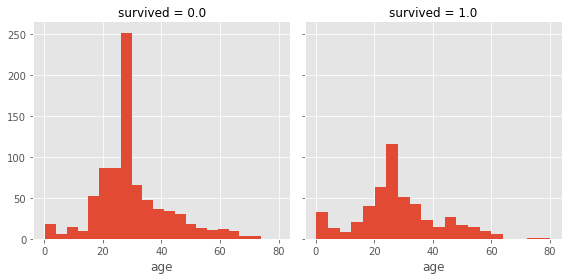

In [12]:
grid = sns.FacetGrid(df, col='survived', size=4)
grid.map(plt.hist, 'age', bins=20)

Regarding having aboard other family members like spouse, children, parents, etc. (eg. __`	sibsp`__ and __`parch`__), shows this trend that having larger family aboard can decrease chance of surviving. These features can be replaced with a new feature presenting family size.

In [13]:
df[['sibsp', 'survived']].groupby('sibsp', as_index=False).mean()

,sibsp,survived
0,0.0,0.346801
1,1.0,0.510972
2,2.0,0.452381
3,3.0,0.300000
4,4.0,0.136364
5,5.0,0.000000
6,8.0,0.000000


Though fare distribution shows some cases of really high amount of fare (eg. outliers), in general __`fare`__ share almost same correlation as passenger class which make sense. Like __`age`__ we will require to encode it into categorical type. However during model development we will decide to consider this feature or not. 

Text(0.5, 1.0, 'Histogram: fare distribution')

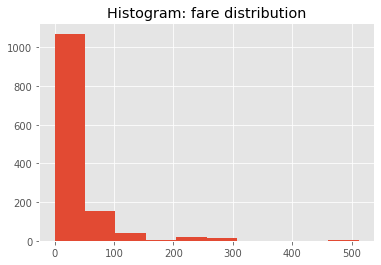

In [14]:
ax = df['fare'].hist()
ax.set_title("Histogram: fare distribution")

In [15]:
df[['pclass', 'fare', 'survived']].groupby('pclass').mean()

,fare,survived
pclass,,
1.0,87.508992,0.619195
2.0,21.179196,0.429603
3.0,13.295480,0.255289


May be not much expected, but there might be kind of correlation between embarkation port and survival. For example, though most of passengers have been embarked from `Southampton`, they happen to have also lowest rate of survival. Well, more investigation may shed some more light on the situation and reveal that  __`embarked`__ is correlated with passenger’s class or fare. In other words, it could be correlated indirectly. However, same as `fare`, we will later decide to consider this as a feature in our model or not.

In [16]:
print(df['embarked'].value_counts())
print("..........................")

df[['embarked', 'survived']].groupby(['embarked'], as_index=False).mean()

S    916
C    270
Q    123
Name: embarked, dtype: int64
..........................


,embarked,survived
0,C,0.555556
1,Q,0.357724
2,S,0.334061


## More on wrangling  

Having a deeper view of data, now should prepare it for model development. To feed a __`classification`__ model by our data, non numeric data should be encoded to numeric type.
1. __`sex`__ will be encoded to `male = 0` and `female = 1`
2. __`age`__  will be split into five groups of age ranges and then encoded as well.
3. __`sibsp`__ and __`parch`__ will be combined to make a new feature __`famsize`__ representing family size.
4. __`fare`__ will be dealt with same as `age`
5. __`embarked`__ will be encoded to `C = 0`, `Q = 1`, and `S = 2`

In [17]:
# encoding 'sex' into ordinal
df['sex'].replace(to_replace=['male', 'female'], value=[0, 1], inplace=True)

In [18]:
# providing insight regarding 'age' categories
df['agecat'] = pd.cut(df['age'], 5)
df[['agecat', 'survived']].groupby('agecat', as_index=False).mean()

,agecat,survived
0,"(0.0869, 16.133]",0.552239
1,"(16.133, 32.1]",0.343075
2,"(32.1, 48.067]",0.397770
3,"(48.067, 64.033]",0.443396
4,"(64.033, 80.0]",0.153846


In [19]:
# encoding 'age' ranges into ordinal data
df.loc[df['age'] <= 16 , 'age'] = 0
df.loc[(df['age'] > 16) & (df['age'] <= 32), 'age'] = 1
df.loc[(df['age'] > 32) & (df['age'] <= 50), 'age'] = 2
df.loc[(df['age'] > 50) & (df['age'] <= 65), 'age'] = 3
df.loc[df['age'] > 65, 'age'] = 4

df.drop(['agecat'], axis=1, inplace = True)

In [20]:
# generating new feature 'famsize' out of dependants aboard including individuals themself
df['famsize'] = df['sibsp'] + df['parch'] + 1
df.drop(['sibsp', 'parch'], axis=1, inplace=True)

In [21]:
# providing insight regarding 'fare' categories
df['farecat'] = pd.cut(df['fare'], 4)
df[['farecat', 'survived']].groupby('farecat', as_index=False).mean()

,farecat,survived
0,"(-0.512, 128.082]",0.364734
1,"(128.082, 256.165]",0.660000
2,"(256.165, 384.247]",0.769231
3,"(384.247, 512.329]",1.000000


In [22]:
# encoding 'fare' ranges into ordinal data
df.loc[df['fare'] <= 128 , 'fare'] = 0
df.loc[(df['fare'] > 128) & (df['fare'] <= 256), 'fare'] = 1
df.loc[(df['fare'] > 256) & (df['fare'] <= 384), 'fare'] = 2
df.loc[df['fare'] > 384, 'fare'] = 3

df.drop(['farecat'], axis=1, inplace = True)

In [23]:
# encoding 'embarked' into ordinal
df['embarked'].replace(to_replace=['C', 'Q', 'S'], value=[0, 1, 2], inplace=True)

In [24]:
df.head()

,pclass,survived,sex,age,fare,embarked,famsize
0,1.0,1.0,1,1.0,1.0,2,1.0
1,1.0,1.0,0,0.0,1.0,2,4.0
2,1.0,0.0,1,0.0,1.0,2,4.0
3,1.0,0.0,0,1.0,1.0,2,4.0
4,1.0,0.0,1,1.0,1.0,2,4.0


## Model Development  

Let’s split the dataset into __65%__ train set and __35%__ test set.

In [25]:
train, test = train_test_split(df, test_size=0.35, random_state=69)

In [26]:
print("train set size: {}".format(train.shape))
print("test set size: {}".format(test.shape))

train set size: (850, 7)
test set size: (459, 7)


For first model we will try __`Decision_Tree_Classifier`__. We will train the model with tree different feature sets to see what works better.

In [27]:
feature1 = ['pclass', 'sex', 'age']
feature2 = ['pclass', 'sex', 'age', 'famsize']
feature3 = ['pclass', 'sex', 'age', 'famsize', 'fare', 'embarked']

To develop the model, need to extract features and target values that model will be fed on them. Moreover, those data should be transferred to __`arrays`__

In [28]:
train_X1, train_y = np.asanyarray(train[feature1]), np.asanyarray(train['survived'])
train_X2 = np.asanyarray(train[feature2])
train_X3 = np.asanyarray(train[feature3])

In [29]:
test_X1, test_y = np.asanyarray(test[feature1]), np.asanyarray(test['survived'])
test_X2 = np.asanyarray(test[feature2])
test_X3 = np.asanyarray(test[feature3])

now it's time to creats models

In [30]:
tree_m1 = DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=69)
tree_m1.fit(train_X1, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=69, splitter='best')

In [31]:
tree_m2 = DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=69)
tree_m2.fit(train_X2, train_y)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=69, splitter='best')

In [32]:
tree_m3 = DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=69)
tree_m3.fit(train_X3, train_y)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=69, splitter='best')

Using `test dataset`, we can have a quick look into models' accuracy. it seems the one developed over `feature2` is perforing better.

In [33]:
pd.DataFrame({
    'Modle': ['tree_m1', 'tree_m2', 'tree_m3'],
    'Score': [tree_m1.score(test_X1, test_y), tree_m2.score(test_X2, test_y), tree_m3.score(test_X3, test_y)]
})

,Modle,Score
0,tree_m1,0.758170
1,tree_m2,0.786492
2,tree_m3,0.782135


Before proceeding with more investigation on the model accuracy, we will also try __`random_forest_classifier`__  to see if we can get a better and more accurate model.  
Though __`random_forest`__ accuracy can change a bit every time the code is run, yet __`decision_tree`__ model with `feature2` is yet the best predicion.

In [34]:
forest_m1 = RandomForestClassifier(n_estimators=100)
forest_m1.fit(train_X2, train_y)
forest_m1.score(test_X2, test_y)

0.7777777777777778

In [35]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [36]:
predict_y = forest_m1.predict(test_X2)
f1_score(test_y, predict_y)

0.711864406779661

In [37]:
# confusion matrix
confusion_matrix(test_y, predict_y, labels=[1, 0])

array([[126,  70],
       [ 32, 231]])

Visualising confusion matrix, seems model has a better performance on predicting 	__`88%`__ of `not_survived` individuals correctly comparing to __`65%`__ correct prediction of `survived` person.

Text(0.5, 1.0, 'Normalized Confusion Matrix')

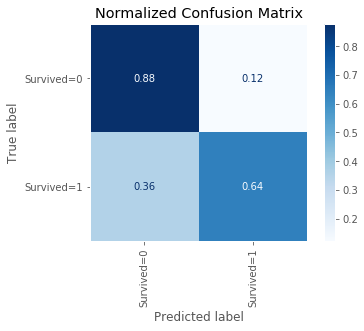

In [38]:
# visualising confusion matrix
plot_confusion_matrix(
    forest_m1, test_X2, test_y, 
    cmap='Blues', 
    display_labels=['Survived=0', 'Survived=1'], 
    normalize='true', 
    xticks_rotation='vertical')
plt.grid(None)
plt.title("Normalized Confusion Matrix")

Let’s have a look at classification reports:

In [39]:
from sklearn.metrics import classification_report

In [40]:
print(classification_report(test_y, predict_y, target_names=['Survived=0', 'survived=1']))

              precision    recall  f1-score   support

  Survived=0       0.77      0.88      0.82       263
  survived=1       0.80      0.64      0.71       196

    accuracy                           0.78       459
   macro avg       0.78      0.76      0.77       459
weighted avg       0.78      0.78      0.77       459



# TODO: Modle needs performance improvement